Instruction for running this leaderboard notebook with the provided :whale: Dockerfile and JupyterLab.

1. Run the command **`docker compose run --rm --service-ports mlzoomcamp`** from the shell of the project base directory
    ```bash
    $ docker compose run --rm --service-ports mlzoomcamp
    ```
    The JupyterLab port defaults to `8888`. If required adapt the JupyterLab port can be changed at container startup by running the following command instead
    ```bash
    $ PORT_JNB=<port> docker compose run --rm --service-ports mlzoomcamp
    ```

2. After you see the shell of the container **`root@mlzoomcamp:/workspace#`** you can easily start JupyterLab using the alias **`jlab`** in the shell of the container. It will use the provided port from container startup.
    ```bash
    `root@mlzoomcamp:/workspace# jlab
    
    ```


# Plotting histogram of total score

Check your placement for total scores.

In [5]:
!pip install lxml ipywidgets
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/usr/local/lib/python3.10/site-packages/jupyterlab/debuglog.py:56: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/usr/local/lib/python3.10/site-packages/jupyterlab/debuglog.py:57: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/usr/local/lib/python3.10/site-packages/jupyterlab/debuglog.py:58: UserWarning: See the log file for details: /tmp/jupyterlab-debug-nov94sro.log
  warnings.warn(f"See the log file for details: {log_path!s}")


***:information_source: Restart kernel after executing the cell above for installing missing libraries.***

In [14]:
from hashlib import sha1
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from typing import Tuple
from IPython.display import display, clear_output

def compute_hash(email):
    return sha1(email.lower().encode('utf-8')).hexdigest()

def read_leaderboard_from_google_spreadsheet(
        url:str='https://docs.google.com/spreadsheets/d/e/2PACX-1vSNK_yGtELX1RJK1SSRl4xiUbD0XZMYS6uwHnybc7Mql-WMnMgO7hHSu59w-1cE7FeFZjkopbh684UE/pubhtml#'
    )->pd.DataFrame:
    list_df = pd.read_html(url, header=1, index_col=0)
    for df in list_df[1:]:
        df.drop(index=np.NaN, inplace=True)
        df.reset_index(drop=True, inplace=True)
    df_leaderboard = list_df[-1]

    return df_leaderboard

def get_your_score_and_position(
        df_leaderboard:pd.DataFrame,
        email_hash:str,
    )->Tuple[int, int]:
    indices = df_leaderboard.email==email_hash
    if indices.any():
        position = df_leaderboard.loc[indices].total.index.to_list()[0]
        total_score = df_leaderboard.loc[indices].total.values[0]
        found = True
    else:
        print('Your email is not found in the leaderboard')
        found = False
        position = np.nan
        total_score = np.nan
    return found, position, total_score

def plot_leaderboard_histogram(
        df_leaderboard:pd.DataFrame, 
        ax:plt.Axes=None,
        your_score:int=np.nan, 
        your_position:int=np.nan,
        marker='o',
        color='orange', 
        ):
    ax = df_leaderboard.total.hist(bins=200, ax=ax, cumulative=True, alpha=.7)
    ax.grid(False)

    n = len(df_leaderboard)
    ax.hlines(n-100, xmin=0, xmax=df_leaderboard.total.max(), color='black', linestyles=':', label='top 100')
    
    if your_score != np.nan:
        ax.scatter(
            x=your_score,
            y=n-your_position,
            color=color,
            marker=marker,
            label='your position'
        )
    ax.set_xlabel('total scores')
    ax.set_title('Check your placement for total scores')
    ax.grid(False)
    ax.legend()
    return ax



In [19]:
df_leaderboard = read_leaderboard_from_google_spreadsheet()
total_score = np.nan
position = np.nan
solved_tasks = df_leaderboard.loc[:, 'email':'total'].columns[1:-1].to_list()
email_hash = ""
text_email = widgets.Text(
    placeholder='your email address',
    disabled=False,
)
text_hash = widgets.Text(
    placeholder='calculated hash',
    disabled=True,
)
text_info = widgets.Textarea(
    placeholder='infos about your placement and total score',
    layout = widgets.Layout(width='800px', height='100px'),
    disabled=True,
)

def on_button_clicked(b):
    global email_hash, total_score, position
    email_hash = compute_hash(text_email.value)
    text_hash.placeholder = email_hash
    found, position, total_score = get_your_score_and_position(
        df_leaderboard,
        email_hash)
    if not found:
        text_info.value = f"Unable to find your email hash in the leaderboard:\nemail:\t'{text_email.value}'\nhash:\t'{email_hash}'"
    else:
        text_info.value = f"email:\t'{text_email.value}'\nhash:\t'{email_hash}'\nposition:\t{position} (zero-based index)\ntotal score:\t{total_score}\n\nsolved tasks:\t{solved_tasks}"

submit_button=widgets.Button(description='>> calculate hash >>',button_style='success')

submit_button.on_click(on_button_clicked)
hbox_hash_calc = widgets.HBox([text_email,submit_button, text_hash])
all_widgets = widgets.VBox([hbox_hash_calc, text_info])
display(all_widgets)

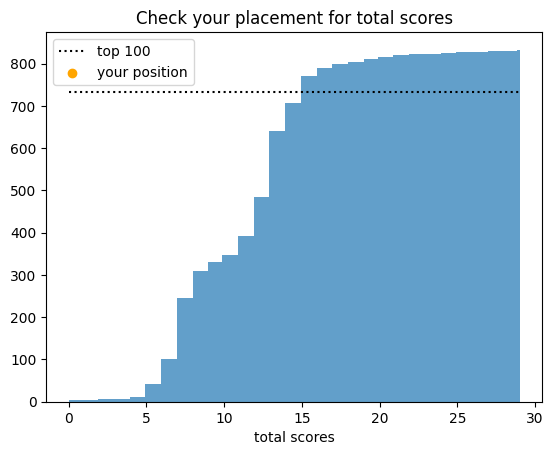

In [20]:
ax = plot_leaderboard_histogram(
        df_leaderboard, 
        your_score=total_score, 
        your_position=position)
plt.show()
